In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import pandas as pd

In [10]:
def cpu_sum(vector):
    result = 0.0
    for i in range(len(vector)):
        result += vector[i]
    return result

@cuda.jit
def gpu_sum_kernel(vector, result):
    temp = cuda.shared.array(512, dtype=np.float32)
    idx = cuda.grid(1)

    if idx < vector.size:
        temp[cuda.threadIdx.x] = vector[idx]
    else:
        temp[cuda.threadIdx.x] = 0.0

    cuda.syncthreads()

    i = cuda.blockDim.x // 2
    while i > 0:
        if cuda.threadIdx.x < i:
            temp[cuda.threadIdx.x] += temp[cuda.threadIdx.x + i]
        cuda.syncthreads()
        i //= 2

    if cuda.threadIdx.x == 0:
        cuda.atomic.add(result, 0, temp[0])

def gpu_sum(vector):
    result = np.zeros(1, dtype=np.float32)
    d_result = cuda.to_device(result)
    d_vector = cuda.to_device(vector)

    threads_per_block = 512
    blocks_per_grid = (vector.size + (threads_per_block - 1)) // threads_per_block
    gpu_sum_kernel[blocks_per_grid, threads_per_block](d_vector, d_result)
    return d_result.copy_to_host()[0]

def measure_time(vector_size):
    vector = np.random.rand(vector_size).astype(np.float32)

    start_time = time.time()
    cpu_result = cpu_sum(vector)
    cpu_time = time.time() - start_time

    start_time = time.time()
    gpu_result = gpu_sum(vector)
    gpu_time = time.time() - start_time

    speedup = cpu_time / gpu_time
    return cpu_time, gpu_time, speedup

   Размер вектора  Время на CPU (с)  Время на GPU (с)  Ускорение
0            1000          0.000398          0.001805   0.220417
1            5000          0.001851          0.001084   1.707875
2           10000          0.002857          0.001024   2.789572
3           50000          0.013008          0.001481   8.785668
4          100000          0.021059          0.000805  26.155167
5          500000          0.112022          0.001659  67.517459
6         1000000          0.227435          0.002632  86.422631


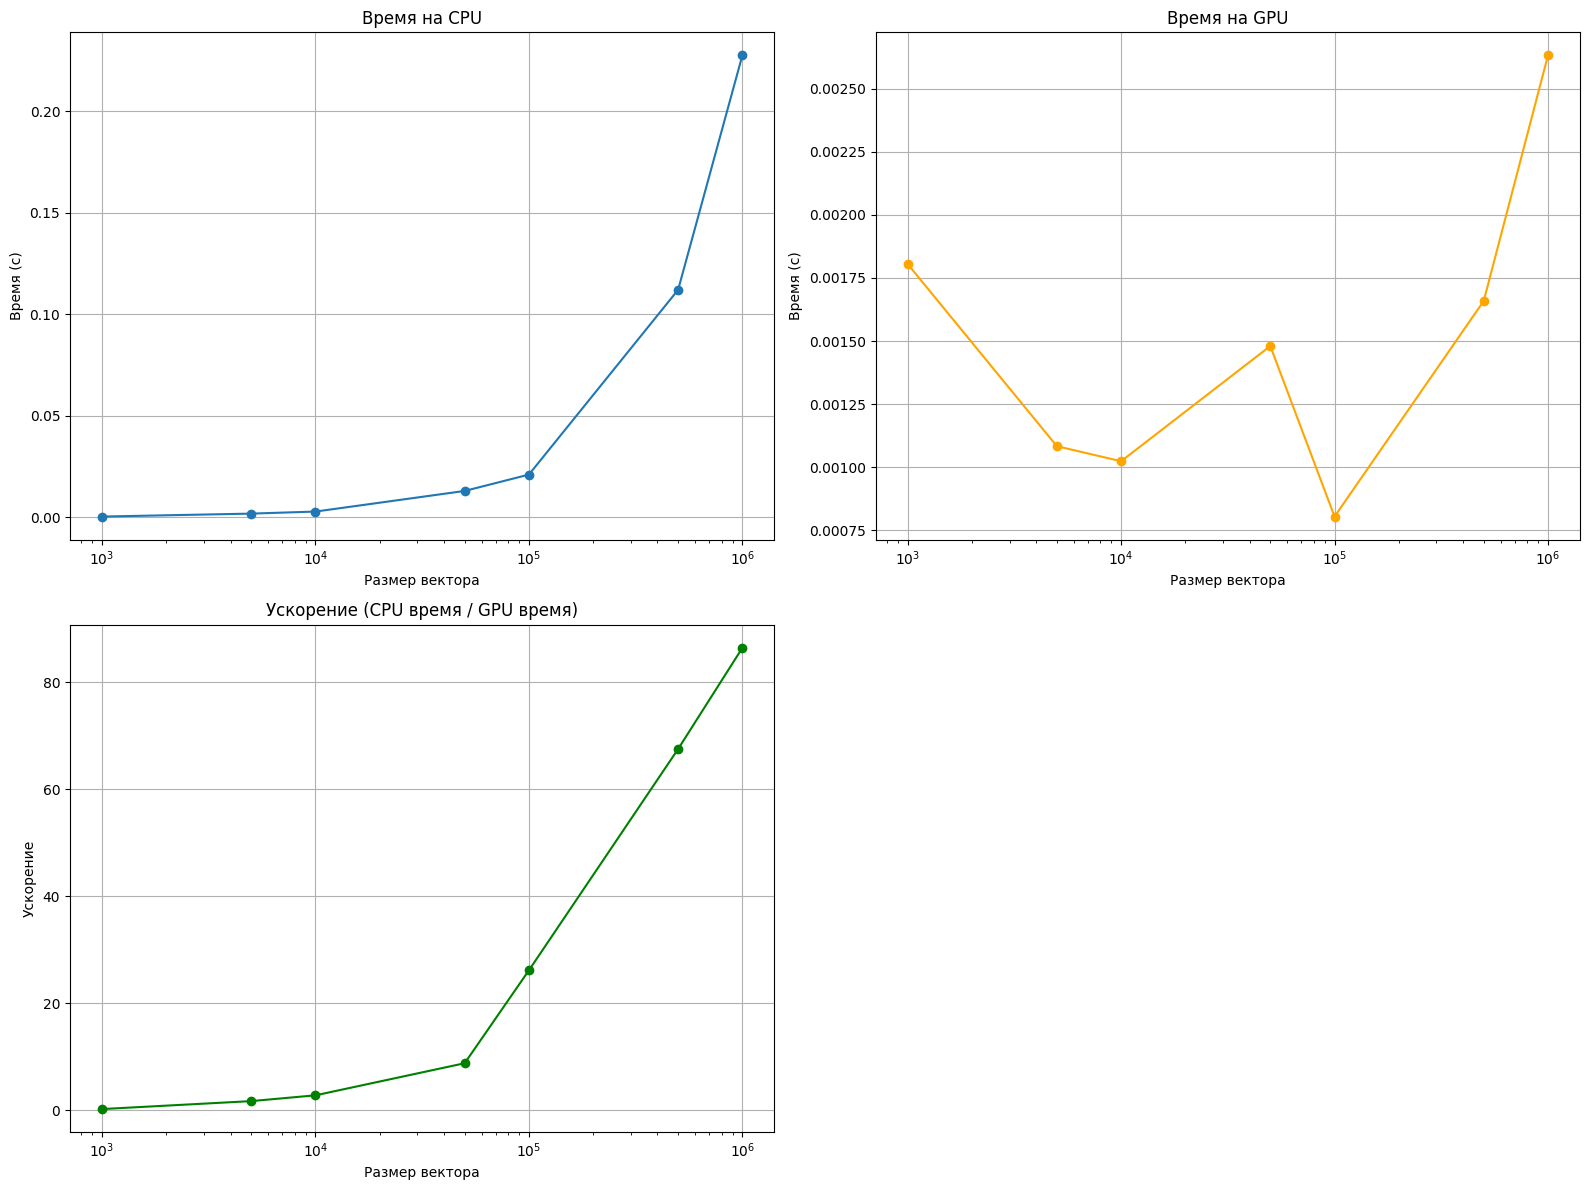

In [30]:
vector_sizes = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
results = {"Размер вектора": [], "Время на CPU (с)": [], "Время на GPU (с)": [], "Ускорение": []}

for size in vector_sizes:
    cpu_time, gpu_time, speedup = measure_time(size)
    results["Размер вектора"].append(size)
    results["Время на CPU (с)"].append(cpu_time)
    results["Время на GPU (с)"].append(gpu_time)
    results["Ускорение"].append(speedup)

df_results = pd.DataFrame(results)
print(df_results)

plt.figure(figsize=(16, 12))

#Время на CPU
plt.subplot(2, 2, 1)
plt.plot(df_results["Размер вектора"], df_results["Время на CPU (с)"], 'o-', label='Время на CPU')
plt.xscale("log")
plt.xlabel("Размер вектора")
plt.ylabel("Время (с)")
plt.title("Время на CPU")
plt.grid(True)

#Время на GPU
plt.subplot(2, 2, 2)
plt.plot(df_results["Размер вектора"], df_results["Время на GPU (с)"], 'o-', label='Время на GPU', color='orange')
plt.xscale("log")
plt.xlabel("Размер вектора")
plt.ylabel("Время (с)")
plt.title("Время на GPU")
plt.grid(True)

#Ускорение
plt.subplot(2, 2, 3)
plt.plot(df_results["Размер вектора"], df_results["Ускорение"], 'o-', label='Ускорение', color='green')
plt.xscale("log")
plt.xlabel("Размер вектора")
plt.ylabel("Ускорение")
plt.title("Ускорение (CPU время / GPU время)")
plt.grid(True)

plt.tight_layout()
plt.show()